# **The New Recruits**
### *Training Day: The Hard Way*

It was one of those moody, rainy days - the kind that smells like old pavement and bad decisions. I was crawling down 85th Ellabell Avenue when Jack called. Old pal. Worse gambler. He’d dug up a fat tip - names that matched some of the suspects piling up in our recent mess. We toss the file at the model, let it make its calls, and pray it doesn’t clock out for a smoke break mid-shift. Then we’ll comb through the results, separate what it actually knows from what it’s just making up. If we’re lucky, maybe the city sleeps a little easier tonight.


---
<br><br>

## **The Setup**
While I am picking my favourite beverage, we should get the files organised, we'll grab the data from the tip to train and validate the models, then we'll give it the real world stuff and let it pick out the bad apples.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv('./Suspects/Train_case_files80.csv')
df_test = pd.read_csv('./Suspects/New_suspects.csv')
df_validation = pd.read_csv('./Suspects/Validation_case_files20.csv')

<br>
We’ve also got ourselves a little lie detector for algorithms. We feed it the ground truth and the model’s bright ideas, and it spits out a confusion matrix — a beautiful little autopsy report for machine intelligence. It shows where the model got it right, where it face-planted, and just how ugly the crime scene got. True positives, false positives, true negatives, false negatives… all the grim details laid out like a coroner’s notes.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_predictions(truth_file, predictions_file, positive_class='innocent', negative_class='guilty'):
    ground_truth = np.loadtxt(truth_file, dtype=str)
    predictions = np.loadtxt(predictions_file, dtype=str)

    # Compute confusion matrix values
    TP = sum((t == positive_class and p == positive_class) for t, p in zip(ground_truth, predictions))
    TN = sum((t == negative_class and p == negative_class) for t, p in zip(ground_truth, predictions))
    FP = sum((t == negative_class and p == positive_class) for t, p in zip(ground_truth, predictions))
    FN = sum((t == positive_class and p == negative_class) for t, p in zip(ground_truth, predictions))

    # Metrics for negative class
    Precision_1 = TN / (TN + FN)
    Recall_1 = TN / (TN + FP)
    F1_1 = 2 * (Precision_1 * Recall_1) / (Precision_1 + Recall_1)
    total_1 = sum(ground_truth == negative_class)

    # Metrics for positive class
    Precision_2 = TP / (TP + FP)
    Recall_2 = TP / (TP + FN)
    F1_2 = 2 * (Precision_2 * Recall_2) / (Precision_2 + Recall_2)
    total_2 = sum(ground_truth == positive_class)

    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    total_3 = total_1 + total_2

    # Create and print metrics table
    data = {
        'Class': [negative_class, positive_class],
        'Precision': [Precision_1, Precision_2],
        'Recall': [Recall_1, Recall_2],
        'F1-Score': [F1_1, F1_2],
        'total': [total_1, total_2]
    }
    df = pd.DataFrame(data)
    print(df.round(2))
    print('accuracy', round(Accuracy, 2), 'total samples:', total_3)

    # Create and display confusion matrix
    conf_matrix = np.array([[TN, FP],
                            [FN, TP]])
    print(conf_matrix)

    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
                xticklabels=[negative_class, positive_class],
                yticklabels=[negative_class, positive_class])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


<br>
The truth file? That’s our gold standard. The machine either matches the truth, or it gets the rookie treatment.

In [3]:
df_validation = pd.read_csv('./Suspects/Validation_case_files20.csv')

suspect_truths = df_validation["suspect"]
print(df_validation["suspect"])

with open("Suspects/Validation_truths.txt", "w") as f:
    for truth in suspect_truths:
        f.write(f"{truth}\n")

0     innocent
1     innocent
2     innocent
3     innocent
4     innocent
        ...   
75    innocent
76    innocent
77    innocent
78      guilty
79      guilty
Name: suspect, Length: 80, dtype: object


---
<br><br>

## **Teaching Machines to Judge**

Time to put the recruits through boot camp.
The Random Forest isn’t some lone wolf - it’s a jury of trees, each one poking at a different piece of the evidence then raising hands for the final call. It’s a cheap trick to keep bias in check and stop one loudmouth tree from running the whole show.


['innocent' 'innocent' 'innocent' 'innocent' 'innocent' 'innocent'
 'innocent' 'innocent' 'guilty' 'guilty' 'innocent' 'guilty' 'guilty'
 'innocent' 'innocent' 'innocent' 'guilty' 'innocent' 'guilty' 'innocent'
 'guilty' 'innocent' 'guilty' 'innocent' 'innocent' 'innocent' 'innocent'
 'innocent' 'innocent' 'innocent' 'innocent' 'innocent' 'innocent'
 'guilty' 'guilty' 'innocent' 'innocent' 'guilty' 'guilty' 'guilty'
 'guilty' 'guilty' 'guilty' 'guilty' 'innocent' 'guilty' 'innocent'
 'innocent' 'guilty' 'guilty' 'innocent' 'innocent' 'innocent' 'guilty'
 'innocent' 'guilty' 'innocent' 'innocent' 'guilty' 'guilty' 'guilty'
 'innocent' 'guilty' 'guilty' 'innocent' 'innocent' 'guilty' 'innocent'
 'innocent' 'guilty' 'innocent' 'innocent' 'guilty' 'innocent' 'innocent'
 'innocent' 'innocent' 'innocent' 'guilty' 'guilty']
Mean accuracy: 0.963, Std: 0.050
      Class  Precision  Recall  F1-Score  total
0    guilty       1.00    0.97      0.98     33
1  innocent       0.98    1.00      0.99  

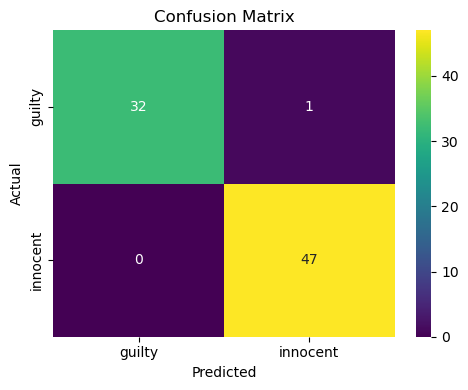

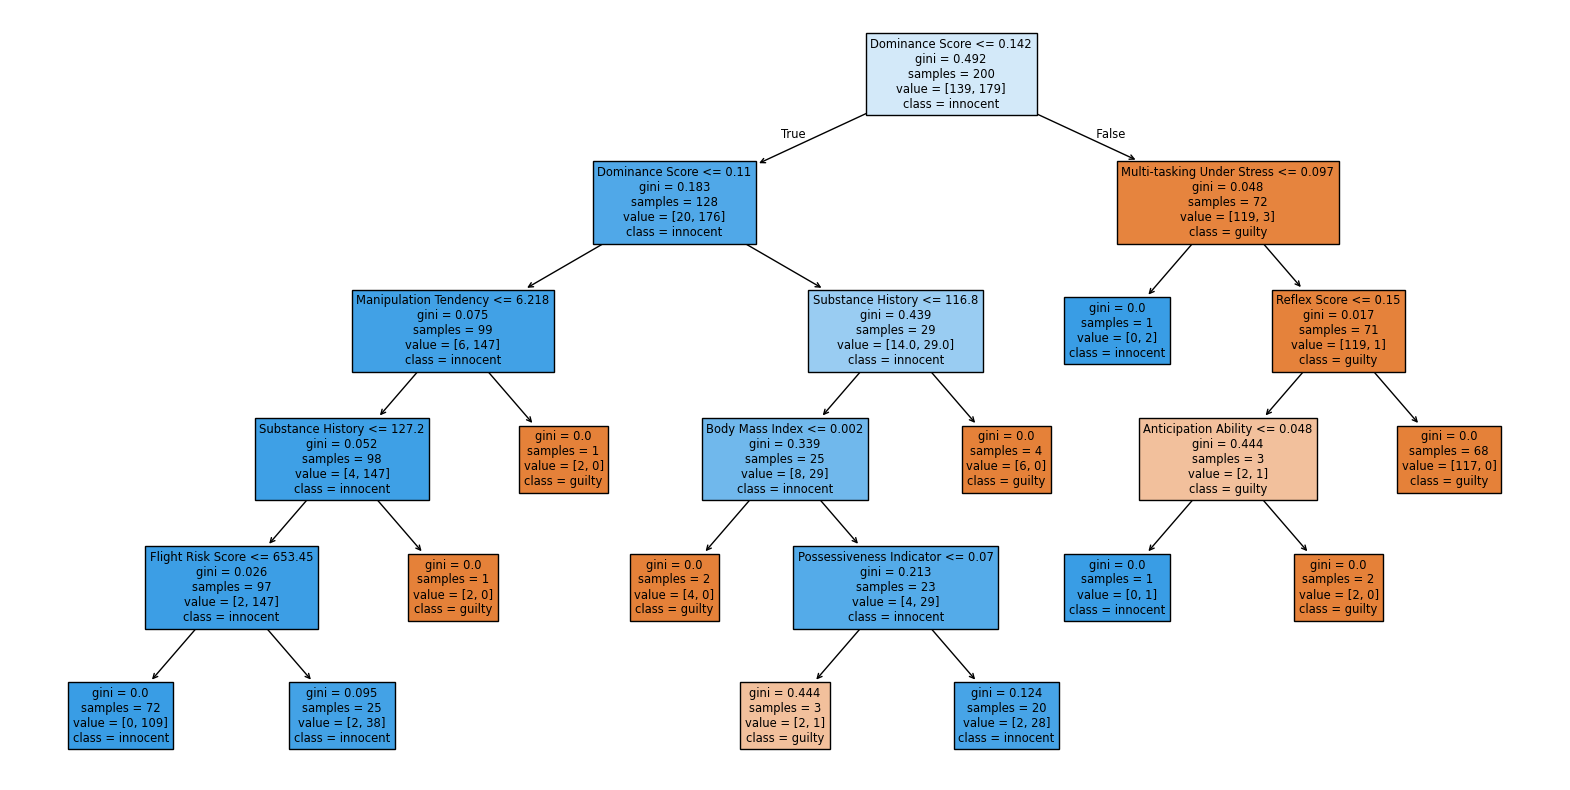

In [4]:
import sys

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

# Extract data from files
train_df = df_train.copy()
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

valid_df = df_validation.copy()
y_valid = valid_df.iloc[:, -1]
X_valid = valid_df[X_train.columns]

test_df = df_test.copy()
y_test = test_df.iloc[:, -1]
X_test = test_df[X_train.columns]

# Train model
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=5,
                             max_features='sqrt',
                             max_leaf_nodes=12,
                             random_state=42)
clf.fit(X_train, y_train)

# Predict
y_valid_pred = clf.predict(X_valid)



# Save predictions to Tree.txt
f1 = f1_score(y_valid, y_valid_pred, average='weighted')
print(y_valid_pred)
with open("Suspects/Tree_predictions_validate.txt", "w") as f:
    for value in y_valid_pred:
        f.write(f"{value}\n")

# Evaluate on validation set
scores = cross_val_score(clf, X_valid, y_valid, cv=5)
print(f"Mean accuracy: {scores.mean():.3f}, Std: {scores.std():.3f}")
evaluate_predictions("Suspects/Validation_truths.txt", "Suspects/Tree_predictions_validate.txt")

# Display data on plot_tree graph
plt.figure(figsize=(20, 10))
tree.plot_tree(clf.estimators_[0], filled=True, feature_names=X_train.columns, class_names=clf.classes_)
plt.show()


Accuracy’s holding at 0.99, mean at 0.963, a little wiggle in the standard deviation, but nothing that smells rotten. Guilty: nailed 32 out of 33. One slipped through the cracks maybe clever, maybe just lucky. Innocent: perfect score. Not a single poor sap got hauled in by mistake.

KNN’s a bit of a street cop - simple, predictable, sometimes too eager to point fingers. So we test different k’s to see which one can actually tell crook from choir boy, then throw it against the wall of truth and let the matrix do its thing.

Best k = 2; f1_score = 0.975
Worst k = 1; f1_score = 0.925


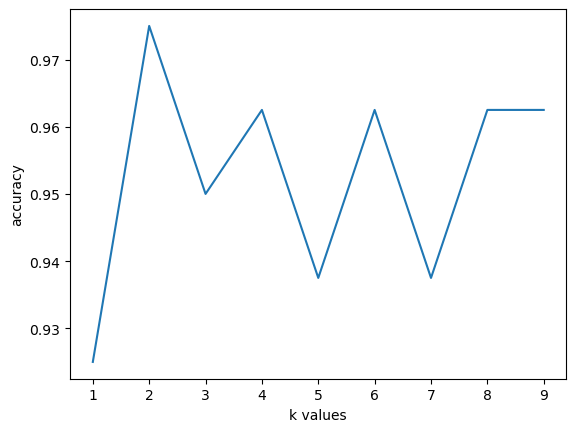

Using k value:  2
      Class  Precision  Recall  F1-Score  total
0    guilty       0.94    1.00      0.97     33
1  innocent       1.00    0.96      0.98     47
accuracy 0.97 total samples: 80
[[33  0]
 [ 2 45]]


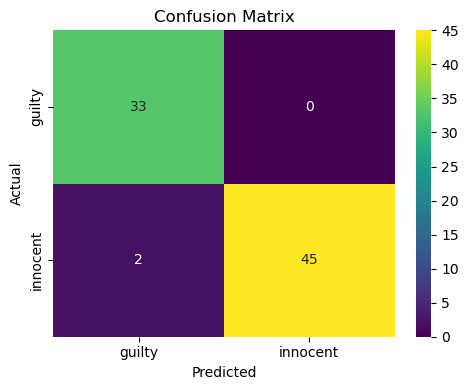

Using k value:  1
      Class  Precision  Recall  F1-Score  total
0    guilty       0.97    0.85      0.90     33
1  innocent       0.90    0.98      0.94     47
accuracy 0.93 total samples: 80
[[28  5]
 [ 1 46]]


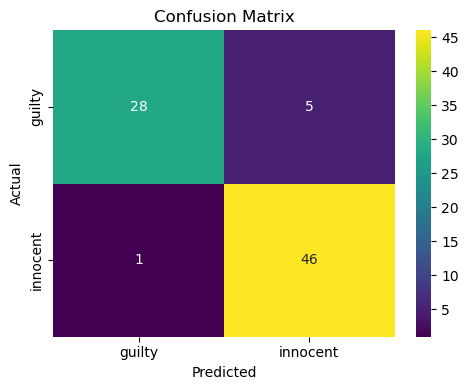

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


# Extract data from files
train_df = df_train.copy()
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

valid_df = df_validation.copy()
y_valid = valid_df.iloc[:, -1]
X_valid = valid_df[X_train.columns]


# Precision % according to the count of k-value
k_values = range(1, 10)
f1_scores = []
for k in k_values :
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_valid)
            acc = accuracy_score(y_valid, y_pred)
            f1_scores.append(acc)

max_f1 = max(f1_scores)
min_f1 = min(f1_scores)
best_k = k_values[f1_scores.index(max_f1)]
worst_k = k_values[f1_scores.index(min_f1)]
print (f"Best k = {best_k}; f1_score = {max_f1}")
print (f"Worst k = {worst_k}; f1_score = {min_f1}")
plt.plot(k_values, f1_scores)
plt.ylabel("accuracy")
plt.xlabel("k values")
plt.show()

# Predict using best k values
k = best_k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
prediction_best = knn.predict(X_valid)

# Predict using worst k values
k = worst_k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
prediction_worst = knn.predict(X_valid)

# Save predictions in a file
with open("Suspects/KNN_best_validate.txt", "w") as f:
        for value in prediction_best:
            f.write(f"{value}\n")

with open("Suspects/KNN_worst_validate.txt", "w") as f:
        for value in prediction_worst:
            f.write(f"{value}\n")

# Evaluate
print("Using k value: ", best_k)
evaluate_predictions("Suspects/Validation_truths.txt", "Suspects/KNN_best_validate.txt")
print("Using k value: ", worst_k)
evaluate_predictions("Suspects/Validation_truths.txt", "Suspects/KNN_worst_validate.txt")




Best k? Two. F1 at 0.975. Nearly spotless. It calls the guilty right, just fumbles a couple of innocents on the way down. Worst k? One. F1 nosedives to 0.925 — suddenly we’ve got false positives strolling in like they know the password. Confusion matrices don’t lie; they draw the chalk outline, mark the body, and tell us exactly how the mess happened.

Then comes the ensemble - KNN, Random Forest, Logistic Regression. Three voices, one verdict. No heart, no gut feeling, just math in a trench coat. We blend their calls together, let soft voting smooth out their screwups, and pray they don’t all trip at once.

      Class  Precision  Recall  F1-Score  total
0    guilty       1.00    0.97      0.98     33
1  innocent       0.98    1.00      0.99     47
accuracy 0.99 total samples: 80
[[32  1]
 [ 0 47]]


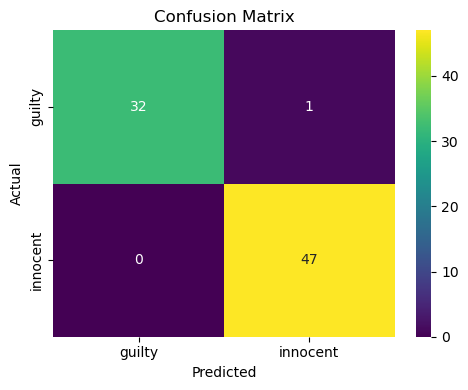

F1-Score on validation set: 0.9895


In [6]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

# Extract data from files
train_df = df_train.copy()
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

valid_df = df_validation.copy()
y_valid = valid_df.iloc[:, -1]
X_valid = valid_df[X_train.columns]

# Define classifiers
clf1 = KNeighborsClassifier(n_neighbors=3)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = LogisticRegression(max_iter=3000)

#Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('knn', clf1),
    ('rf', clf2),
    ('lr', clf3)
], voting='soft')

# Train model
voting_clf.fit(X_train, y_train)

# Evaluate on validation set
y_pred_val = voting_clf.predict(X_valid)
f1 = f1_score(y_valid, y_pred_val, pos_label='innocent')
with open("Suspects/Voting_predictions_validate.txt", "w") as f:
    for label in y_pred_val:
        f.write(f"{label}\n")
evaluate_predictions("Suspects/Validation_truths.txt", "Suspects/Voting_predictions_validate.txt")
print(f"F1-Score on validation set: {f1:.4f}")

Accuracy at 0.99. The squad saw what a bunch of pairs of eyes couldn’t. It should've been a triumph. Instead, it was just math proving the obvious.

---
<br><br>

## **Reality Check**

Fresh cases on the table. No more warm-ups. We feed the model the test set, slap on the predictions, and crack it open with histograms and scatterplots.


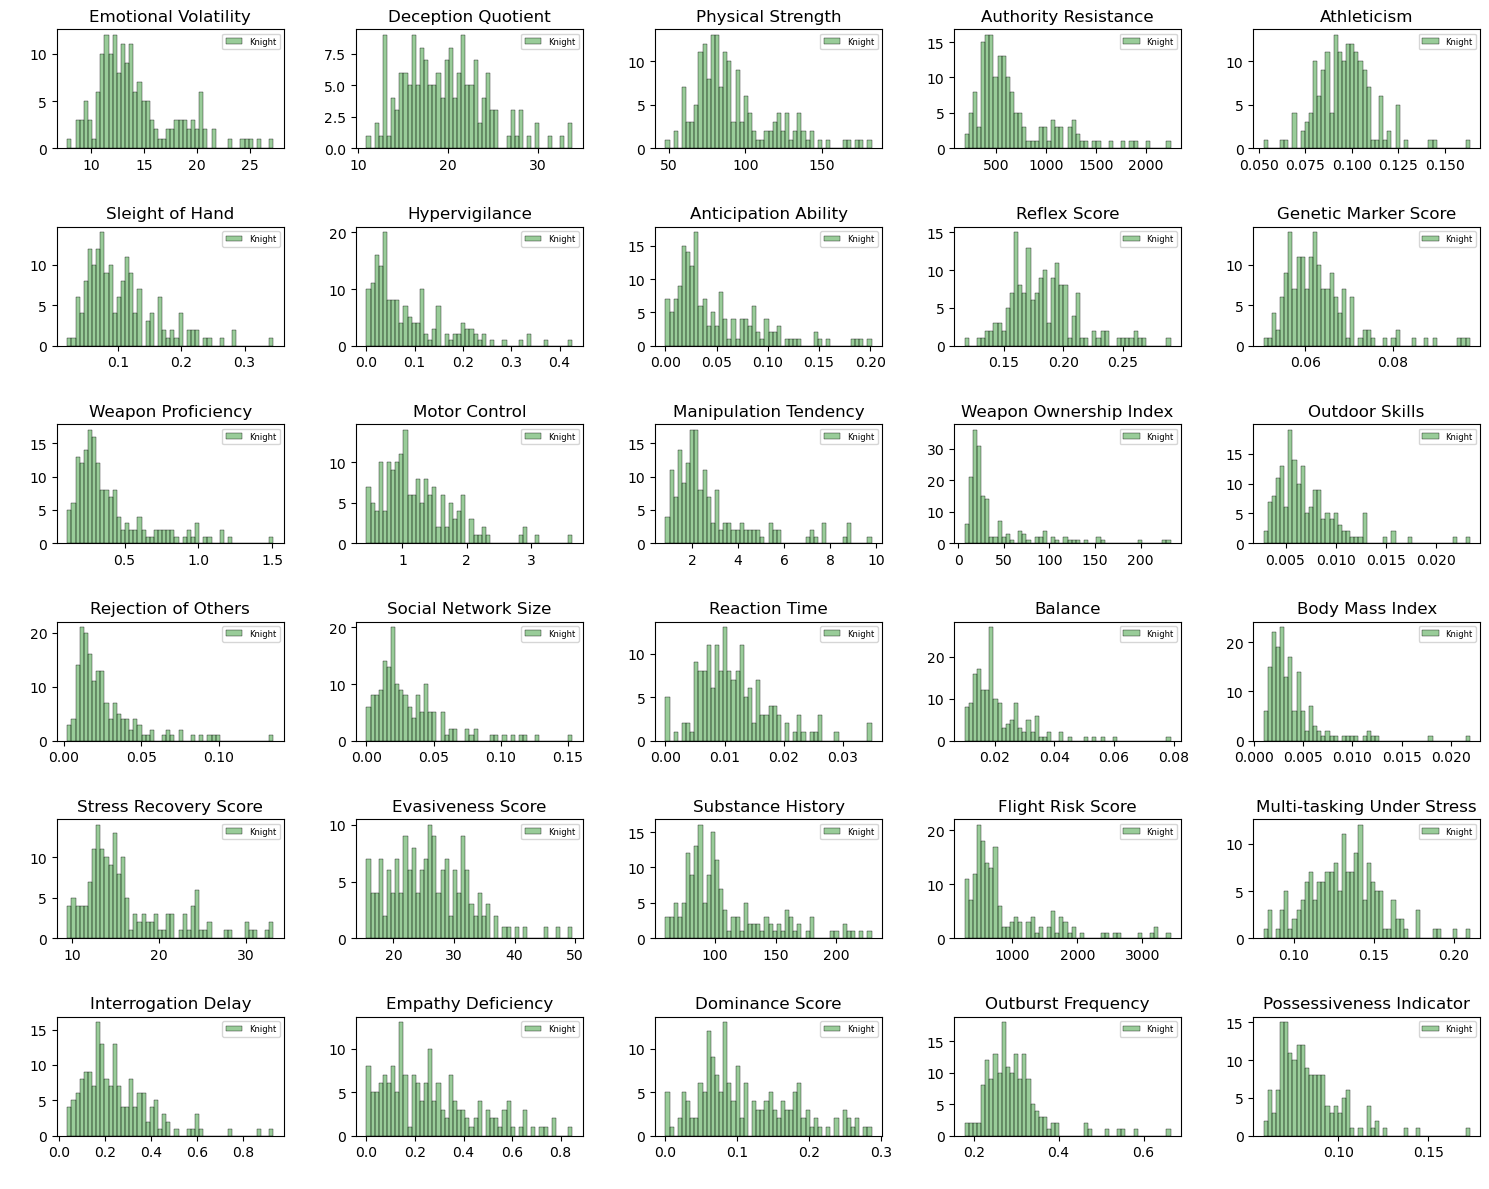

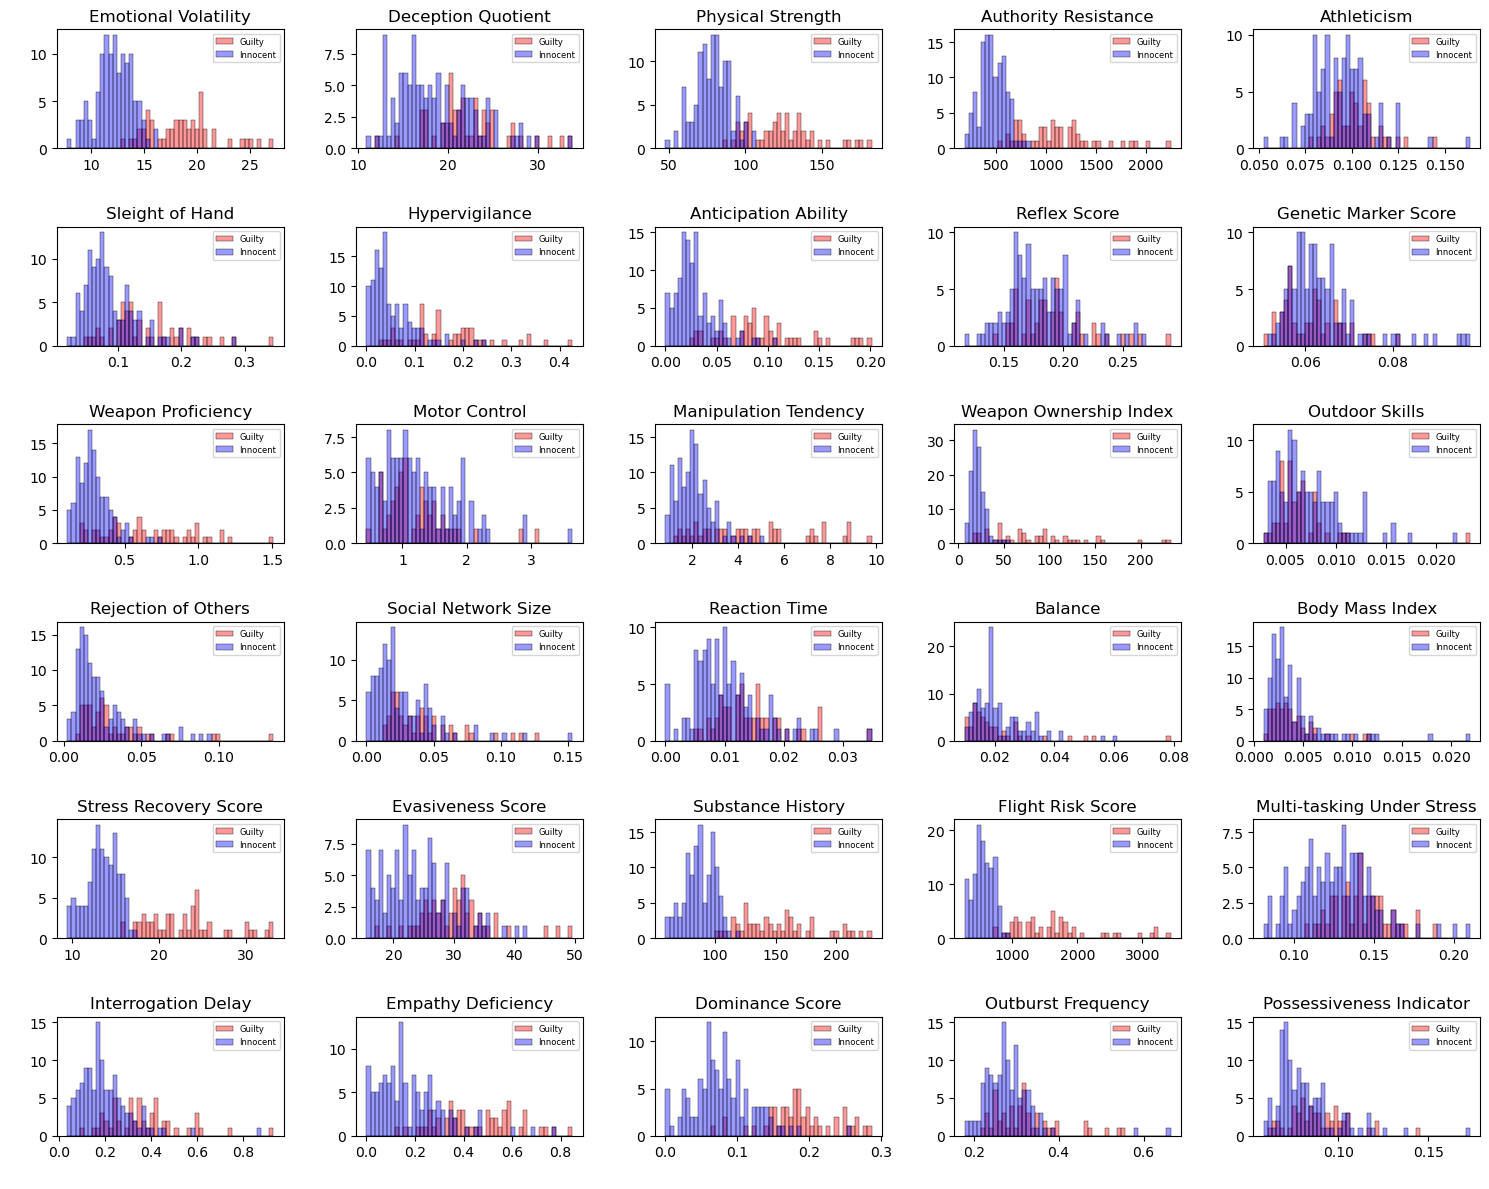

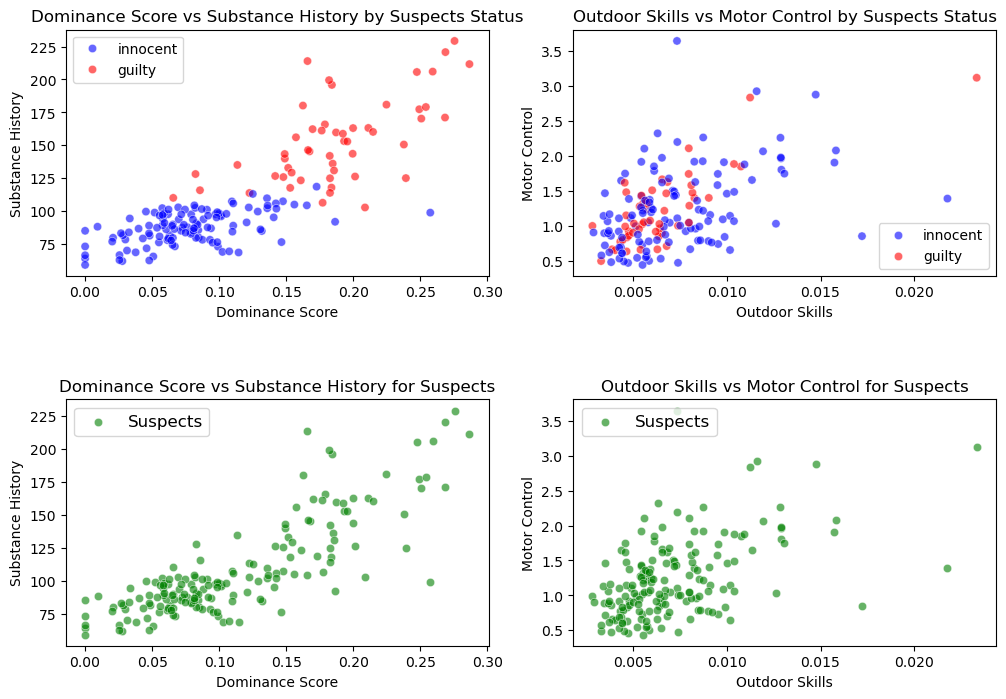

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns

y_pred_val_test = voting_clf.predict(X_test)
df_test = pd.read_csv('./Suspects/New_suspects.csv')
df_test_predicted = df_test.copy()
df_test_predicted['suspect'] = y_pred_val_test

# Select only numeric columns
numeric_cols = df_test_predicted.select_dtypes(include='number').columns

# Set up the grid size
num_items = len(numeric_cols)
cols = 5
rows = (num_items + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 2 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_test,
                 x=col,
                 bins=50,
                 ax=axes[i],
                 kde=False,
                 color='green',
                 alpha=0.4)   
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(' ')
    axes[i].set_ylabel(' ')
    axes[i].legend(['Knight'], loc='upper right', fontsize=6)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 2 * rows))
axes = axes.flatten()  # Flatten 2D array of axes to 1D for easy indexing

# Plot each numeric column
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_test_predicted,
                 x=col,
                 bins=50,
                 ax=axes[i],
                 hue='suspect',
                 palette=['blue', 'red'],
                 kde=False,
                 alpha=0.4)   
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(' ')
    axes[i].set_ylabel(' ')
    axes[i].legend(['Guilty', 'Innocent'], loc='upper right', fontsize=6)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)

plt.subplot(2,2,1)
sns.scatterplot(data=df_test_predicted, x='Dominance Score', y='Substance History', hue='suspect', alpha=0.6, palette={'innocent': 'blue', 'guilty': 'red'})
plt.legend()
plt.title("Dominance Score vs Substance History by Suspects Status")

plt.subplot(2,2,2)
sns.scatterplot(data=df_test_predicted, x='Outdoor Skills', y='Motor Control', hue='suspect', alpha=0.6, palette={'innocent': 'blue', 'guilty': 'red'})
plt.legend()
plt.title("Outdoor Skills vs Motor Control by Suspects Status")


plt.subplot(2,2,3)
sns.scatterplot(data=df_test, x='Dominance Score', y='Substance History', alpha=0.6, color='green')
plt.legend(['Suspects'], loc='upper left', fontsize=12)
plt.title("Dominance Score vs Substance History for Suspects")

plt.subplot(2,2,4)
sns.scatterplot(data=df_test, x='Outdoor Skills', y='Motor Control', alpha=0.6, color='green')
plt.legend(['Suspects'], loc='upper left', fontsize=12)
plt.title("Outdoor Skills vs Motor Control for Suspects")
plt.show()


The usual static: BMI, Outdoor Skills, Motor Control. Useless. But the signals were clear: Dominance Score, Anticipation, Substance History. Still sharp. The clean split held. The model saw the same chalk outline twice. No surprises, kid. It wasn't bluffing.

---
<br>

## **Case Closed**

The rain’s still tapping the windshield when I hit 85th again. Same street. Different case. Jeff “The Eye” Mallory would’ve loved this one - clean splits, sharp signals, no fog left to squint through.

The models held. Noise got tossed. The real traits stood tall. KNN flinched, the forest didn’t, and the squad together saw what one pair of eyes couldn’t.

I light a cigarette, roll past the busted streetlight, and smile. For once, the machine didn’t blink first.

---
<br>